In [1]:
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import shapely

import clima_anom as ca

import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [2]:
date_file = '201408'

In [3]:
andes = list(shpreader.Reader('../mapping/andes_1000.shp').geometries())

In [37]:
# Filtered Data from SA
file_in = '/mnt/Data/Data/PF/rgpf_SA/rgpf_'+date_file+'_level2.csv'
data = pd.read_csv(file_in)
print(file_in)

/mnt/Data/Data/PF/rgpf_SA/rgpf_201408_level2.csv


In [38]:
orbits_ids = np.unique(data['ORBIT'].values)
orbits_num = len(orbits_ids)
print('Number of orbits: ', orbits_num)

Number of orbits:  223


In [39]:
PF_GPD = gpd.GeoDataFrame(geometry=gpd.points_from_xy(data['lon'],data['lat'], crs="EPSG:4326"))

In [40]:
#Using IMERG 05x05 grid
data = ca.read_netcdf('/mnt/Data/Data/IMERG/season/summer/IMERG_2000_12_2020_12_24h_05x05_summer.nc',0)
lat = data['lat'].data
lon = data['lon'].data

lon2d, lat2d = np.meshgrid(lon, lat)

nlat = len(lat)
nlon = len(lon)

res_y = lat[1]-lat[0]
res_x = lon[1]-lon[0]

del data

print(f'Latitude points   : {nlat}')
print(f'Longitude points  : {nlon}')
print(f'Spatial resolution: {res_x}x{res_y}')

Latitude points   : 120
Longitude points  : 110
Spatial resolution: 0.5x0.5


In [70]:
# Lat and Lon of the grid
grid_lat_lon = gpd.GeoDataFrame(geometry=gpd.points_from_xy(np.reshape(lon2d,(nlat*nlon)),np.reshape(lat2d,(nlat*nlon)), crs="EPSG:4326"))

In [85]:
xmin, ymin, xmax, ymax= np.min(lon2d)-0.25,np.min(lat2d)+0.25,np.max(lon2d)-0.25,np.max(lat2d)+0.25

# how many cells across and down
cell_size_y=0.5
cell_size_x=0.5

# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size_x, cell_size_x ):
    for y0 in np.arange(ymin, ymax+cell_size_y, cell_size_y):
        # bounds
        x1 = x0+cell_size_x
        y1 = y0-cell_size_y
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:4326")

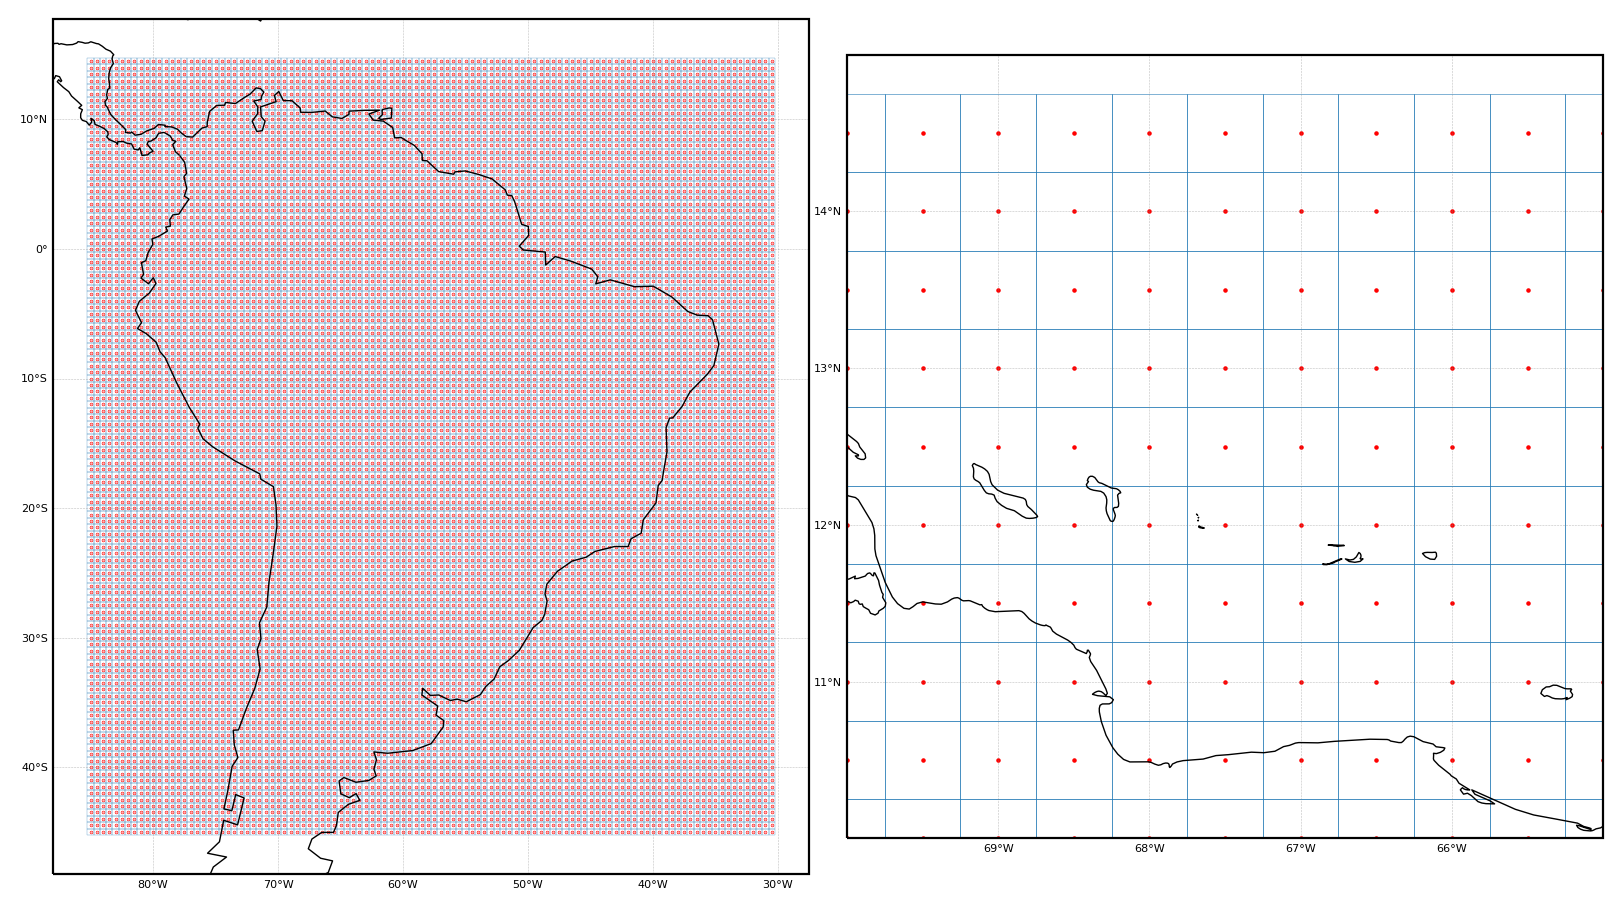

In [109]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10),dpi=200)
gs = gridspec.GridSpec(1,2)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.5,color='black',zorder=4)
# ax1.set_extent([-85,-30,-46,15],crs=proj)
# ax1.set_extent([-80,-70,0,15],crs=proj)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cell.boundary.plot(ax=ax1,linewidth=0.1)
grid_lat_lon.plot(ax=ax1,markersize=0.05, marker='o',color='r')


#=====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.5,color='black',zorder=4)
# ax1.set_extent([-85,-30,-46,15],crs=proj)
ax1.set_extent([-65,-70,10,15],crs=proj)
cell.boundary.plot(ax=ax1,linewidth=0.2)
grid_lat_lon.plot(ax=ax1,markersize=0.4, marker='o',color='r')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

#=====================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.05, wspace=0.05)


In [199]:
merged = gpd.sjoin(PF_GPD, cell, how='left', op='within')
merged['n_fires']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
cell.loc[dissolve.index, 'n_fires'] = dissolve.n_fires.values

#replace NaN with 0
salida = cell.fillna(0)

/home/arturo/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


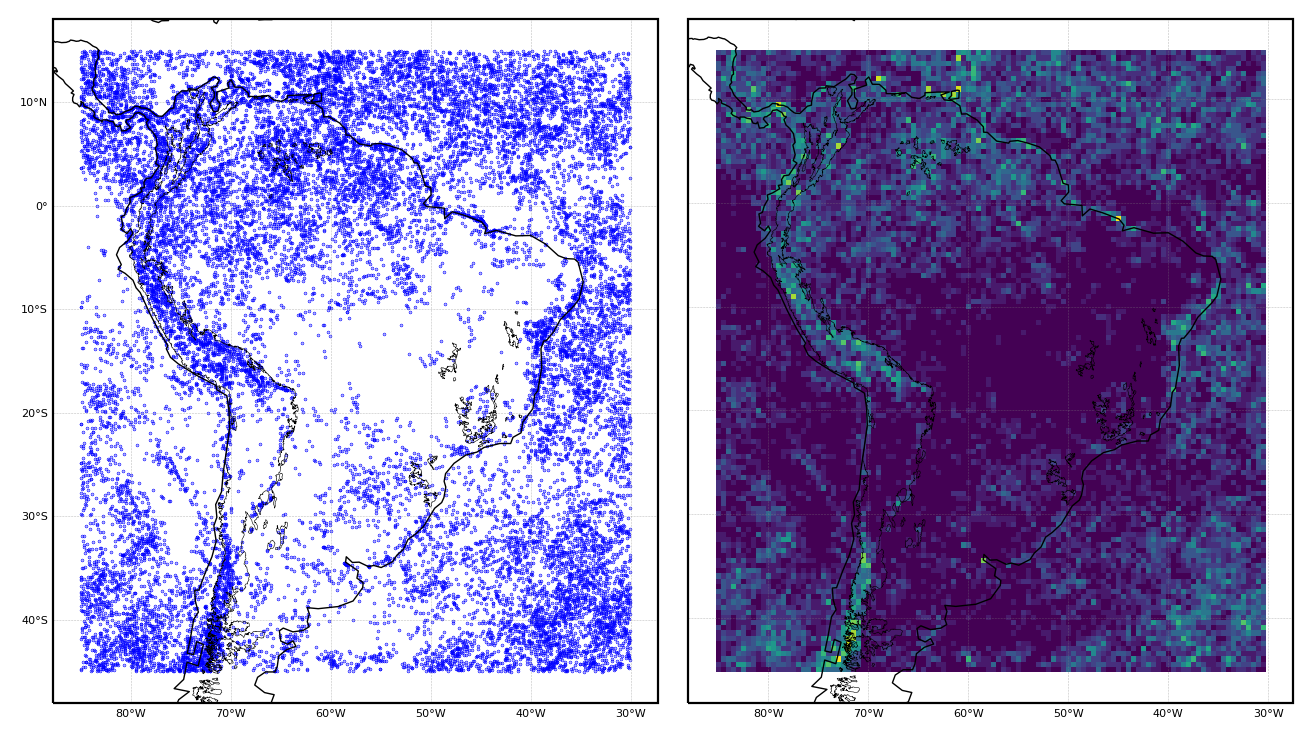

In [213]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=200)
gs = gridspec.GridSpec(1,2)

#=====================================================================================================
ax1 = plt.subplot>(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.5,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.2,zorder=5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

PF_GPD.plot(markersize=0.05, marker='o',color='b', ax=ax1)


#=====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.5,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.2,zorder=5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = salida.plot("n_fires", ax=ax1)

#=====================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.05, wspace=0.05)

In [238]:
data_out = salida['n_fires'].values.reshape(nlon, nlat).T

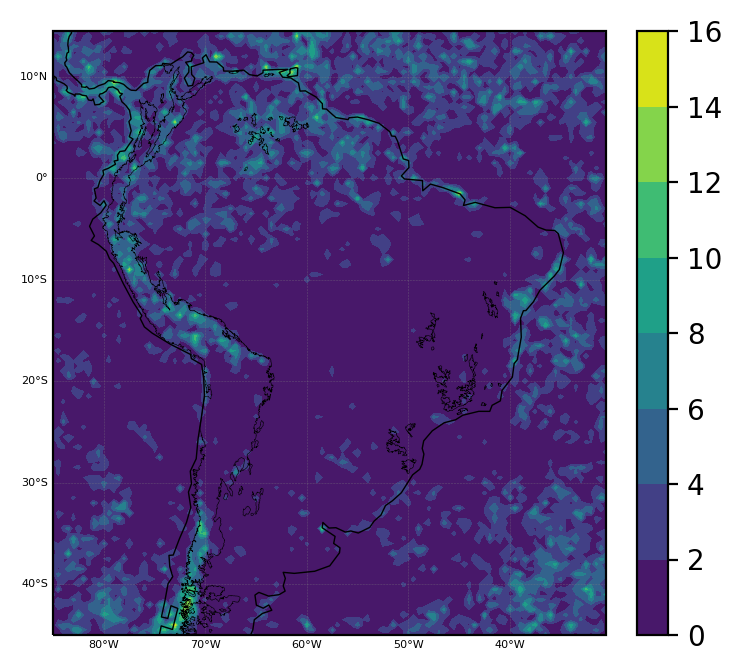

In [245]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=200)
gs = gridspec.GridSpec(1,1)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.5,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.2,zorder=5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.contourf(lon2d, lat2d, data_out)
plt.colorbar(a1,fraction=0.05)